### Figure 2: Distribution Plot

In [22]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import xesmf as xe
from utils.data import load_tc_data
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# TODO: think about how to combine extreme set
# TODO: NH / SH separation

In [23]:
def plot_histogram(real,inputs, pred_cnn,pred_vaegan, pred_dsrnngan, binwidth,alpha,type='Mean'):
        """
        This function plots a histogram of the set in question
        """
        # ax = sns.histplot(data=penguins, x="flipper_length_mm", hue="species", element="step")
        fig, ax = plt.subplots(figsize=(10, 5))
      #   fig, ax = plt.subplots(figsize=(5, 5))
        sns.histplot(ax=ax,data=real, stat="density", fill=True,color='#cdeac0',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=inputs, stat="density", fill=True,color='#efe9ae',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=pred_cnn, stat="density", fill=True,color='#fec3a6',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=pred_vaegan, stat="density", fill=True,color='#ff928b',element='step',alpha=alpha)
        sns.histplot(ax=ax,data=pred_dsrnngan, stat="density", fill=True,color='#ffac81',element='step',alpha=alpha)
        ax.set_xlabel('Mean or Peak rainfall (mm/h)',size=18)
        ax.set_xlabel('%s Rainfall (mm/h)' % type,size=18)
        ax.set_ylabel('Density',size=18)
        plt.legend(labels=['real','input','cnn','vaegan','dsrnngan'],fontsize=24)
        plt.show()
        # plt.savefig('figs/histogram_accumulated_%s.png' % mode)

def calc_peak(array):
        nstorms,_,_ = array.shape
        peaks = np.zeros((nstorms))
        for i in range(nstorms):
                peaks[i] = np.nanmax(array[i])
        return peaks

def calc_mean(array):
        nstorms,_,_ = array.shape
        means = np.zeros((nstorms))
        for i in range(nstorms):
                means[i] = np.nanmean(array[i])
        return means

def ridgeline_plot(reals,inputs,unet,vaegan,wgan,n,peak=True):
      print('peak is ',peak)
      sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
      x = []
      print(n)
      # for i in range(len(reals)):
      for i in range(n):
            x.append(inputs[i])
            x.append(unet[i])
            x.append(vaegan[i])
            x.append(wgan[i])
            x.append(reals[i])

      g = np.tile(['A','B','C','D','E'], n)
      df = pd.DataFrame(dict(x=x, g=g))
      m = df.g.map(ord)

      # Initialize the FacetGrid object
      pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
      # g = sns.FacetGrid(df, row="g", hue="g", aspect=15, height=1, palette=pal)
      g = sns.FacetGrid(df, row="g", hue="g", aspect=10, height=1, palette=pal)

      # Draw the densities in a few steps
      if peak == True:
            clip = (-1, 120)
      else:
            clip = (-1, 35)
      g.map(sns.kdeplot, "x",
            bw_adjust=.5, clip_on=False,
            fill=True, alpha=1, linewidth=1.5,clip=clip)
      g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5,clip=clip)


      # passing color=None to refline() uses the hue mapping
      g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


      # Define and use a simple function to label the plot in axes coordinates
      def label(x, color, label):
            ax = plt.gca()
            if label == 'A':
                  label = 'INPUTS'
            elif label == 'B':
                  label = 'UNET'
            elif label == 'C':
                  label = 'VAEGAN'
            elif label == 'D':
                  label = 'WGAN'
            elif label == 'E':
                  label = 'REAL'    
            elif label == 'F':
                  label = 'HRMIP'
            ax.text(0, .2, label, fontweight="bold", color=color,
                        ha="left", va="center", transform=ax.transAxes)

      # last_ax = g.axes.flat[-1] #this might put the x axis right
      g.map(label, "x")

      # Set the subplots to overlap
      g.figure.subplots_adjust(hspace=-.25)

      # Remove axes details that don't play well with overlap
      g.set_titles("")
      print(peak)
      if peak == True:
            g.set(yticks=[], ylabel="",xlabel="Peak rainfall (mm/h)")
      elif peak == False:
            print('mean')
            g.set(yticks=[], ylabel="",xlabel="Mean rainfall (mm/h)")
      # g.set_xlabels("Peak rainfall (mm/h)",fontweight='bold',color='#425782',size=15)
      g.set_xticklabels(size = 12,fontweight='bold',color='#425782')
      g.despine(bottom=True, left=True)
      print(peak)
      if peak == True:
            g.savefig('peak_distribution.png')
      else:
            g.savefig('mean_distribution.png')

def distribution(inputs,pred_unet,pred_vaegan,pred_gan,real,pred_mip,peak=True):
	peak_reals = calc_peak(real)
	peak_preds = calc_peak(pred_gan)
	peak_inputs = calc_peak(inputs)
	peak_vaegan = calc_peak(pred_vaegan)
	peak_cnn = calc_peak(pred_unet)
	peak_hrmip = calc_peak(pred_mip)
	# plot_histogram(peak_reals,peak_inputs,peak_cnn,peak_vaegan,peak_preds,5,0.5,type = 'Peak')

	mean_reals = calc_mean(real)
	mean_preds = calc_mean(pred_gan)
	mean_inputs = calc_mean(inputs)
	mean_vaegan = calc_mean(pred_vaegan)
	mean_cnn = calc_mean(pred_unet)
	mean_hrmip = calc_mean(pred_mip)

	# plot_histogram(mean_reals,mean_inputs,mean_cnn,mean_vaegan,mean_preds,5,0.5)

	# print('mean real: ',np.mean(real))
	# print('mean pred: ', np.mean(pred))
	# print('std real: ',np.std(real))
	# print('std pred: ',np.std(pred))
	if peak:
		return peak_reals,peak_preds,peak_inputs,peak_vaegan,peak_cnn,peak_hrmip
	else:
		return mean_reals,mean_preds,mean_inputs,mean_vaegan,mean_cnn,mean_hrmip

def radMask(index,radius,array):
  a,b = index
  nx,ny = array.shape
  y,x = np.ogrid[-a:nx-a,-b:ny-b]
  mask = x*x + y*y <= radius*radius

  return mask

def core(data,radius=25):
      print('data shape',data.shape)
      mask=radMask((50,50),radius,data[0,:,:])
      n,_,_ = data.shape
      mask = np.expand_dims(mask,axis=0)
      mask = np.repeat(mask,n,axis=0)
      return np.ma.array(data, mask=mask)

In [24]:

model = ''
# set mode
mode = 'validation'
# print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)

pred_gan = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_5_normal_problem.npy',allow_pickle=True)[0,:,:,0]
print('pred gan shape',pred_gan.shape)
# load datasets

real,inputs,pred_cnn,pred_vaegan,pred_gan,pred_vaegan_ensemble,pred_gan_ensemble,meta = load_tc_data(set='validation',results='test')
real_x,inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,pred_vaegan_ensemble_x,pred_gan_ensemble_x,meta_extreme_valid = load_tc_data(set='extreme_valid',results='test')
inputs = np.load('/user/home/al18709/work/gan_predictions_20/validation_input-opt_improve.npy')[:,:,:,0]
hrmip = np.load('/user/home/al18709/work/CMIP6/HighResMIP/EC-Earth3p/historical/storm_rain.npy')[-28000:]

# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)
hrmip_hr = regridder(hrmip)


pred gan shape (100, 100)


In [25]:
reals = core(real)
inputs = core(inputs_hr)
pred_cnn = core(pred_cnn)
pred_vaegan = core(pred_vaegan)
pred_gan = core(pred_gan)
real = core(real)



data shape (16253, 100, 100)
data shape (16253, 100, 100)
data shape (16252, 100, 100)
data shape (16253, 100, 100)
data shape (16253, 100, 100)
data shape (16253, 100, 100)


In [26]:


# pred = inputs_hr
peak_reals,peak_gan,peak_inputs,peak_vaegan,peak_unet,peak_hrmip = distribution(inputs,pred_cnn,pred_vaegan,pred_gan,real,hrmip)
mean_reals,mean_gan,mean_inputs,mean_vaegan,mean_unet,mean_hrmip = distribution(inputs,pred_cnn,pred_vaegan,pred_gan,real,hrmip,peak=False)

peak is  True
16252
True
True


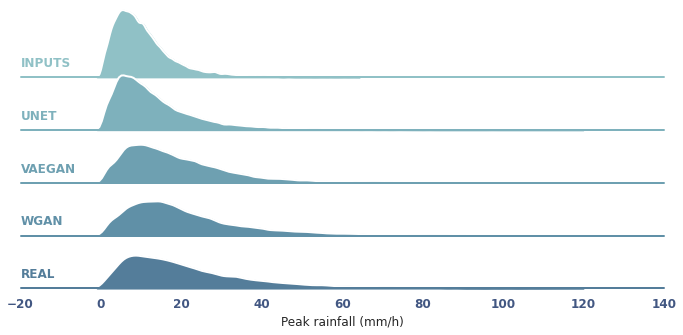

In [27]:
n, = peak_reals.shape
ridgeline_plot(peak_reals,peak_inputs,peak_unet,peak_vaegan,peak_gan,n-1)
# ridgeline_plot(mean_reals,mean_inputs,mean_unet,mean_vaegan,mean_gan,n-1,peak=False)



In [28]:
# print(x)
# https://python.plainenglish.io/ridge-plots-with-pythons-seaborn-4de5725881af
print(real_x.shape)
peak_reals,peak_dsrnngan,peak_inputs,peak_vaegan,peak_unet,peak_hrmip = distribution(inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,hrmip)
mean_reals,mean_dsrnngan,mean_inputs,mean_vaegan,mean_unet,mean_hrmip = distribution(inputs_x,pred_cnn_x,pred_vaegan_x,pred_gan_x,real_x,hrmip,peak=False)

(5425, 100, 100)


(5425,) (5425,) (5425,) (5425,) (5425,)
data shape (5425, 100, 100)
data shape (5425, 10, 10)
data shape (5425, 100, 100)
data shape (5425, 100, 100)
data shape (5425, 100, 100)
data shape (5425, 100, 100)
peak is  True
5425
True
True


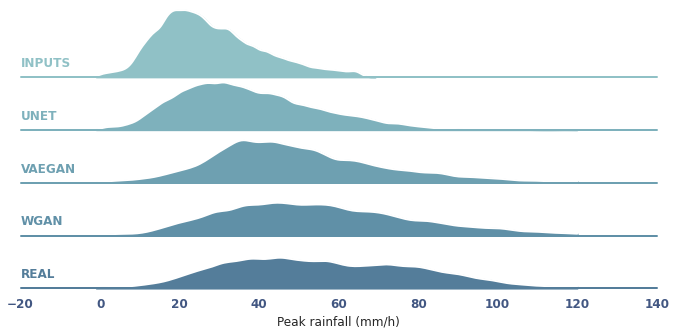

In [29]:
print(peak_reals.shape,peak_inputs.shape,peak_unet.shape,peak_vaegan.shape,peak_dsrnngan.shape)
reals = core(real_x)
inputs = core(inputs_x)
pred_cnn = core(pred_cnn_x)
pred_vaegan = core(pred_vaegan_x)
pred_dsrnngan = core(pred_gan_x)
real = core(real_x)
n, = peak_reals.shape
ridgeline_plot(peak_reals,peak_inputs,peak_unet,peak_vaegan,peak_dsrnngan,n)
# ridgeline_plot(mean_reals,mean_inputs,mean_unet,mean_vaegan,mean_dsrnngan,n)